In [255]:
import tensorflow as tf

In [256]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## A test function with 2 variables

This will be the function:
f(x, y) = 0.2 * (x - 1) ^ 2 + 0.3 * (y - 2) ^ 2

In [257]:
offset = np.asarray([1, 2])
qcoef = np.asarray([0.2, 0.3])

In [258]:
def test_function_1(x):
    x1 = x - offset
    x2 = x1 * x1
    return np.dot(x2, qcoef)

In [259]:
test_function_1(np.asarray([0, 0]))

1.3999999999999999

## Measurements are noisy
We generate a bunch of noisy measurements around a given current point

In [260]:
cov = np.asarray([[1, 0], [0, 1]])

In [261]:
def generate_measurements(n, x0, varx=1, varm=1):
    x = np.random.multivariate_normal(x0, cov * varx, n)
    noise = np.random.randn(n) * varm
    return x, test_function_1(x) + noise

In [262]:
x, m = generate_measurements(3, [1, 1], 0.2, 0.1)
print(x)
print(m)

[[ 0.54844545  0.5142837 ]
 [ 1.3141976   1.31530634]
 [ 1.03882567  1.45071744]]
[ 0.60973842  0.07153776  0.01396643]


## Optimizing
We have an iterative process of 4 steps:
- generate a few noisy measurements around the current x
- test the current model on them
- integrate the new measurements into training data and train a new model
- based on the new model make a step from current x to maximize the given function

In [263]:
import keras
from keras.models import Sequential
from keras import layers as L

In [283]:
INPUT_DIM = 2
#HIDDEN = (2 * INPUT_DIM, 2 * INPUT_DIM, INPUT_DIM, INPUT_DIM)
#HIDDEN = (INPUT_DIM, 2 * INPUT_DIM, INPUT_DIM, INPUT_DIM)
HIDDEN = (4 * INPUT_DIM, 2 * INPUT_DIM, 2 * INPUT_DIM, INPUT_DIM, INPUT_DIM)
lr_pred = 1e-4
lr_opt = 1e-1

In [284]:
sess = tf.InteractiveSession()

In [306]:
predictor = Sequential()
predictor.add(L.InputLayer([INPUT_DIM],name='measure'))
for i, h in enumerate(HIDDEN):
    predictor.add(L.Dense(h, activation='relu', name='dense_'+str(i)))
predictor.add(L.Dense(1, name='output'))

In [307]:
predictor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
measure (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_0 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total para

In [286]:
x0 = np.asarray([[0, 0]], 'float32')
y0 = np.asarray([[0]], 'float32')

In [287]:
current_x = tf.Variable(x0, name='current_x')
measure_x = tf.placeholder('float32', [None, INPUT_DIM])
measure_y = tf.placeholder('float32', [None, 1])

In [288]:
predict_y = predictor(measure_x)
predictor_loss = tf.losses.mean_squared_error(measure_y, predict_y)

In [289]:
current_y = predictor(current_x)
optimizer_loss = tf.losses.mean_squared_error(y0, current_y)

In [290]:
predictor.trainable_weights

[<tf.Variable 'dense_21/kernel:0' shape=(2, 8) dtype=float32_ref>,
 <tf.Variable 'dense_21/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'dense_22/kernel:0' shape=(8, 4) dtype=float32_ref>,
 <tf.Variable 'dense_22/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'dense_23/kernel:0' shape=(4, 4) dtype=float32_ref>,
 <tf.Variable 'dense_23/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'dense_24/kernel:0' shape=(4, 2) dtype=float32_ref>,
 <tf.Variable 'dense_24/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'dense_25/kernel:0' shape=(2, 2) dtype=float32_ref>,
 <tf.Variable 'dense_25/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'output_5/kernel:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'output_5/bias:0' shape=(1,) dtype=float32_ref>]

In [291]:
current_x

<tf.Variable 'current_x_5:0' shape=(1, 2) dtype=float32_ref>

In [292]:
predictor_opt = tf.train.GradientDescentOptimizer(lr_pred).minimize(predictor_loss, var_list=predictor.trainable_weights)
optimizer_opt = tf.train.GradientDescentOptimizer(lr_opt).minimize(optimizer_loss, var_list=[current_x])

### Training data accumulates

In [293]:
no_meas = 16
batch_size = 16
max_points = 1024
#ps_max = 0.3
#ps_min = 0.05
point_spread = 0.3
meas_sigma = 0.1
opt_steps = 100
pre_steps = 500

In [294]:
train_x = None
train_y = None
permut = None
mse = []
tx = []
ty = []
tl = []

In [295]:
def get_batch(k):
    i = k * batch_size % train_x.shape[0]
    p = permut[i : i + batch_size]
    return train_x[p,], train_y[p,]

In [296]:
def integrate_train(tx, ty, x, y):
    if tx is None:
        tx = x
        ty = y
    else:
        tx = np.vstack((tx, x))[:max_points,]
        ty = np.vstack((ty, y))[:max_points,]
        
    per = np.random.permutation(tx.shape[0])
    return tx, ty, per

In [297]:
sess.run(tf.global_variables_initializer())

In [298]:
for step in range(opt_steps):
    # Current optimization point
    xc = sess.run(current_x)[0]
    tx.append(xc[0])
    ty.append(xc[1])
    
    # Generate new measurements around it
    x, y = generate_measurements(no_meas, xc, point_spread, meas_sigma)
    y = np.reshape(y, (no_meas, 1))
    
    # Test the old model on the new measurements
    p_loss = sess.run(predictor_loss, {measure_x: x, measure_y: y})
    mse.append(p_loss)
    print('Pred loss:', p_loss)
    
    # Now we lower point spread when we predict well
    #point_spread = max(ps_min, min(point_spread, p_loss))
    
    # Integrate new point to the training set
    train_x, train_y, permut = integrate_train(train_x, train_y, x, y)
    
    # Train a new model
    for k in range(pre_steps):
        x, y = get_batch(k)
        t_loss, _ = sess.run([predictor_loss, predictor_opt], {measure_x: x, measure_y: y})
        tl.append(t_loss)
    
    # Make a step to the new optimum
    _ = sess.run(optimizer_opt)

#xc = sess.run(current_x)

Pred loss: 2.77812
Pred loss: 2.94824
Pred loss: 2.49115
Pred loss: 2.37443
Pred loss: 1.41177
Pred loss: 0.789694
Pred loss: 0.907695
Pred loss: 1.31652
Pred loss: 1.47424
Pred loss: 0.90241
Pred loss: 0.508538
Pred loss: 0.646805
Pred loss: 0.926811
Pred loss: 0.67593
Pred loss: 0.644852
Pred loss: 0.621036
Pred loss: 0.530612
Pred loss: 0.385594
Pred loss: 0.468964
Pred loss: 0.575078
Pred loss: 0.393051
Pred loss: 0.379815
Pred loss: 0.185802
Pred loss: 0.282978
Pred loss: 0.29055
Pred loss: 0.197142
Pred loss: 0.206913
Pred loss: 1.53698
Pred loss: 0.27094
Pred loss: 0.346072
Pred loss: 0.36778
Pred loss: 0.267404
Pred loss: 0.425191
Pred loss: 0.474131
Pred loss: 0.324584
Pred loss: 0.376647
Pred loss: 0.609654
Pred loss: 0.321908
Pred loss: 0.50616
Pred loss: 0.379759
Pred loss: 0.379589
Pred loss: 0.319571
Pred loss: 0.404796
Pred loss: 0.368573
Pred loss: 0.301564
Pred loss: 0.341072
Pred loss: 0.231311
Pred loss: 0.138064
Pred loss: 0.165948
Pred loss: 0.179705
Pred loss: 0.1

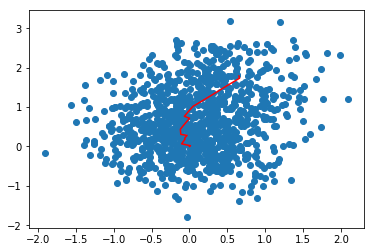

In [299]:
plt.scatter(train_x[:, 0], train_x[:, 1])
plt.plot(tx, ty, 'r')
plt.show()

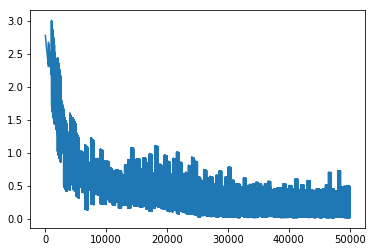

In [300]:
plt.plot(tl)
plt.show()

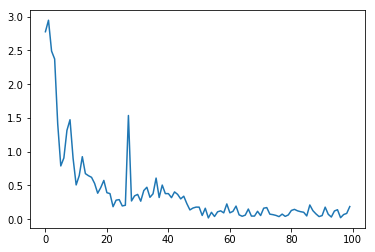

In [301]:
plt.plot(mse)
plt.show()